In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


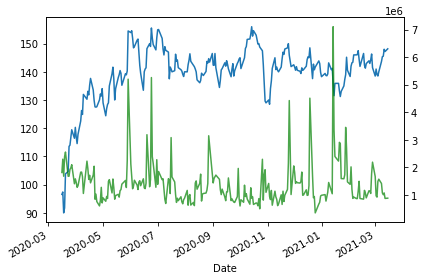

In [67]:
google=pd.read_csv('GOOG.csv',parse_dates=['Date'],index_col='Date')
netflix=pd.read_csv('nflx.csv',parse_dates=['Date'],index_col='Date')
nio=pd.read_csv('nio.csv',parse_dates=['Date'],index_col='Date')
dominos=pd.read_csv('dpz.csv',parse_dates=['Date'],index_col='Date')
disney=pd.read_csv('dis.csv',parse_dates=['Date'],index_col='Date')
apple=pd.read_csv('aapl.csv',parse_dates=['Date'],index_col='Date')
vmware=pd.read_csv('VMW.csv',parse_dates=['Date'],index_col='Date')
microsoft=pd.read_csv('MSFT.csv',parse_dates=['Date'],index_col='Date')

df=vmware.copy()

#df['Date']=pd.to_datetime(df['Date'])
#df=df.set_index('Date')
df=df.sort_values(by='Date',ascending=True)
print(df.columns)
fig,ax=plt.subplots(figsize=(6,4))
df['Open'].plot(ax=ax)
twin_ax=ax.twinx()

df['Volume'].plot(ax=twin_ax, c='green', alpha=0.7)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



In [68]:
#df=df.asfreq('B').fillna(0)
#for key, item in df.iterrows():
#    print(key,item)

In [69]:
df['Shifted 1D']=df.Open.shift()
df['Shifted 2D']=df.Open.shift(periods=2)
df['Open_PCT']=df['Open'].pct_change()

df["Buy_Count"]=0

for index in range(len(df)):
    count=0
    for index2 in (range(index,0,-1)):
        if df.iloc[index2]["Open_PCT"]>0:
            count=count+1
        else:
            break
    df.iloc[index, df.columns.get_loc('Buy_Count')]=count
    
df['Action']=[ 'Sell' if x['Buy_Count']==0 else 'Buy' if x['Buy_Count']==2 else 'Hold' if x['Buy_Count'] > 2 else 'No Action' for key,x in df.iterrows()]

df["Target"]=0
for index in range(len(df)):
    action=df.iloc[index]["Action"]
    if (action=='Buy'):
             df.iloc[index, df.columns.get_loc('Target')]=1
    elif (action=='Sell'):
             df.iloc[index, df.columns.get_loc('Target')]=2

print(df[['Target','Action','Open_PCT','Open','Shifted 1D','Shifted 2D','Buy_Count']])



            Target     Action  Open_PCT        Open  Shifted 1D  Shifted 2D  \
Date                                                                          
2020-03-16       2       Sell       NaN   96.559998         NaN         NaN   
2020-03-17       0  No Action  0.008803   97.410004   96.559998         NaN   
2020-03-18       2       Sell -0.076070   90.000000   97.410004   96.559998   
2020-03-19       0  No Action  0.019556   91.760002   90.000000   97.410004   
2020-03-20       1        Buy  0.131757  103.849998   91.760002   90.000000   
...            ...        ...       ...         ...         ...         ...   
2021-03-09       0       Hold  0.011902  145.380005  143.669998  140.000000   
2021-03-10       0       Hold  0.001032  145.529999  145.380005  143.669998   
2021-03-11       0       Hold  0.016972  148.000000  145.529999  145.380005   
2021-03-12       2       Sell -0.005405  147.199997  148.000000  145.529999   
2021-03-15       0  No Action  0.006522  148.160004 

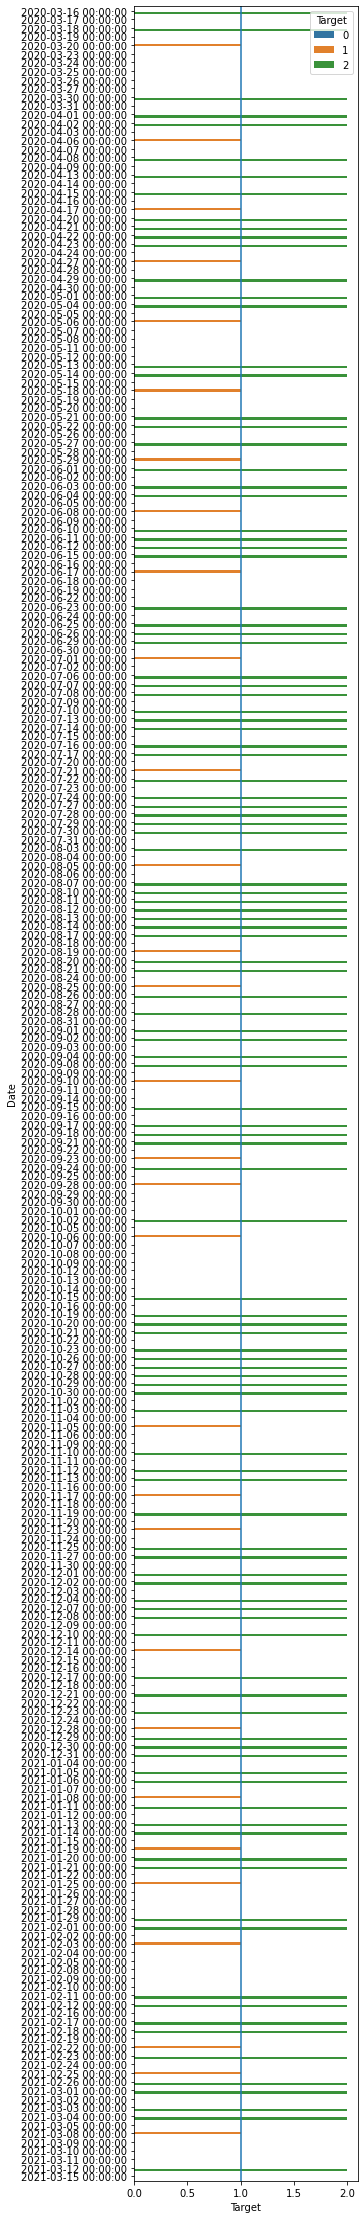

In [70]:
colors=[]
[colors.append('Red') if x=='2' else colors.append('Green') if x==1 else colors.append('White') for x in df['Target']]
plt.figure(figsize=(4, 40))
#names.arg = colors
sns.barplot(data=df, x='Target', y=df.index, hue='Target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.show()

   Buy_Count  Incidence  Size
0          0          2   115
1          1          0    60
2          2          1    30
3          3          0    19
4          4          0    12
5          5          0     8
6          6          0     4
7          7          0     3
8          8          0     1
Number of Buys in the Data 19
Number of days holding Open          47
High          47
Low           47
Close         47
Adj Close     47
Volume        47
Shifted 1D    47
Shifted 2D    47
Open_PCT      47
Buy_Count     47
Action        47
Target        47
dtype: int64
Incidence shows the average target value for each group


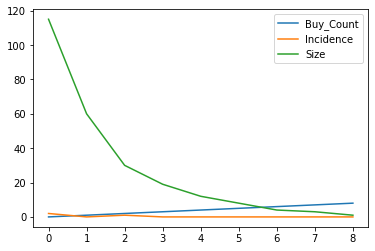

In [71]:
def create_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
    
    pig_table=groups[target].agg([np.mean, np.size]).reset_index()
    pig_table=pig_table.rename(columns={'mean':'Incidence','size':'Size'})
    #pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()

    # Return the predictor insight graph table
    return pig_table

pig_table = create_pig_table(df, "Target", "Buy_Count")
print(pig_table)

print("Number of Buys in the Data", len(df[df['Buy_Count']==3]))

print("Number of days holding", df[(df["Action"]=='Hold')].count())

print("Incidence shows the average target value for each group")

pig_table.plot()
plt.show()

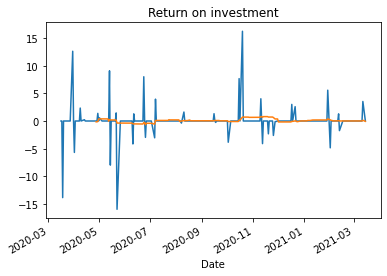

In [72]:
#df['Return']=df[df['Open']]
sellAmt=0
sellIndex=0
buyAmt=0
df['Return']=0
previousAction=""
for index in range(len(df)):
    count=0
    for index2 in (range(index,0,-1)):
        row=df.iloc[index2]
        #Print(row.Action, row.Open, row.Return)
        if row.Action=='Sell':
            if previousAction=='Sell':
                break
            sellAmt=row.Open
            sellIndex=index2
        if row.Action=='Buy' and (previousAction=='Hold' or previousAction=='Sell'):
            #print("Buy", sellIndex,index2)
            buyAmt=row.Open
            #print("Return",  previousAction, buyAmt,sellAmt,index2,sellIndex)
            df.iloc[sellIndex, df.columns.get_loc('Return')]=sellAmt-buyAmt
            break
        if row.Action=='No Action':
            break
        previousAction=row.Action
            
    #df.iloc[index, df.columns.get_loc('Buy_Count')]=count

#for key,item in df.iterrows():
#    print(item.Action,item.Open, "Return", item.Return)


df['Return_Avg'] = df['Return'].rolling(
    window=30,
    center=False
).mean()

df['Return'].plot()
df['Return_Avg'].plot()
plt.title('Return on investment')
plt.show()

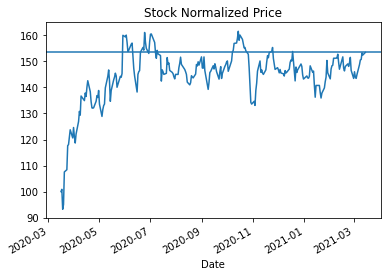

In [73]:
first_price=df['Open'].iloc[0]
last_price=df['Open'].iloc[len(df)-1]/first_price*100

normalized=df.Open.div(first_price).mul(100)
normalized.plot(title='Stock Normalized Price')
plt.axhline(y=last_price, xmin=0, xmax=1)
plt.show()


<AxesSubplot:xlabel='Date'>

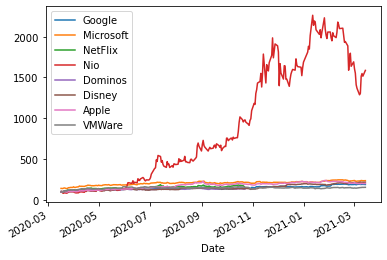

In [78]:
compare=google.merge(microsoft['Open'],on='Date',how='left').rename(columns={'Open_x':'Google','Open_y':'Microsoft'}).drop(columns=['Volume','High','Low','Close','Adj Close'])
compare=compare.merge(netflix['Open'],on='Date',how='left').rename(columns={'Open':'NetFlix'})
compare=compare.merge(nio['Open'],on='Date',how='left').rename(columns={'Open':'Nio'})
compare=compare.merge(dominos['Open'],on='Date',how='left').rename(columns={'Open':'Dominos'})
compare=compare.merge(disney['Open'],on='Date',how='left').rename(columns={'Open':'Disney'})
compare=compare.merge(apple['Open'],on='Date',how='left').rename(columns={'Open':'Apple'})
compare=compare.merge(vmware['Open'],on='Date',how='left').rename(columns={'Open':'VMWare'})

compare.Google=compare.Google.div(compare.Google.iloc[0]).mul(100)
compare.NetFlix=compare.NetFlix.div(compare.NetFlix.iloc[0]).mul(100)
compare.Nio=compare.Nio.div(compare.Nio.iloc[0]).mul(100)
compare.Dominos=compare.Dominos.div(compare.Dominos.iloc[0]).mul(100)
compare.Disney=compare.Disney.div(compare.Disney.iloc[0]).mul(100)
compare.Apple=compare.Apple.div(compare.Apple.iloc[0]).mul(100)
compare.VMWare=compare.VMWare.div(compare.VMWare.iloc[0]).mul(100)
#print(compare)
compare.plot()